# Read the dataset and import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# read from google drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/Walmart_Sales.csv'
data = pd.read_csv(file_path)

#check the data loading
data.head()

Mounted at /content/drive


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# data preprocessing
* convert date time value and order the dataset by date time for
time series model usage
* check and process for missing value
* since the original dataset is using the store 1 and 2 as the store id which implys ordering in this column so we use one hot encoding here to erase that implicit ordering
*data normalization with Standardization method for numerical values

In [ ]:
# Step 1: Preprocessing
# Convert Date to datetime and extract features
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['Day'] = data['Date'].dt.day

# Drop the original Date column
data.drop(columns=['Date'], inplace=True)

# Separate features and target variable
X = data.drop(columns=['Weekly_Sales'])
y = data['Weekly_Sales']

# Identify categorical and numerical columns
categorical_cols = ['Store', 'Holiday_Flag']
numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day']

# Build preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(y_train_final.shape)
print(X_train_final.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
# Fit and transform the training, validation, and test datasets
X_train_final = preprocessor.fit_transform(X_train_final)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
# Scale the target variable ------ check why redo standard scaler here
scaler_y = StandardScaler()
y_train_final = scaler_y.fit_transform(y_train_final.values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = y_test.values#scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

(4118,)
(4118, 10)
(1030, 10)
(1030,)
(1287, 10)
(1287,)


#Build the model

In [ ]:
# Step 2: Build the Feedforward Neural Network (FNN)
def build_model(input_dim, num_layers=5, neurons_per_layer=128, activation='relu', dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation=activation, input_dim=input_dim))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['root_mean_squared_error'])
    return model

# Model parameters
input_dim = X_train_final.shape[1]
baseline_model = build_model(input_dim, num_layers=5, neurons_per_layer=128, dropout_rate=0.2, learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train model

In [ ]:
# Step 3: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

baseline_history = baseline_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.8649 - root_mean_squared_error: 0.9252 - val_loss: 0.1421 - val_root_mean_squared_error: 0.3770
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1541 - root_mean_squared_error: 0.3923 - val_loss: 0.0746 - val_root_mean_squared_error: 0.2730
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1193 - root_mean_squared_error: 0.3449 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2549
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0960 - root_mean_squared_error: 0.3095 - val_loss: 0.0628 - val_root_mean_squared_error: 0.2506
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0751 - root_mean_squared_error: 0.2739 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0666 - root_mean_squared_error: 0.2578 - val_loss: 0.0781 - val_root_mean_squared_error: 0.2794
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

#Model evaluation

In [ ]:
# # Step 4: Evaluate the Model
# loss, rmse = model.evaluate(X_test, y_test, verbose=0)
# print(f"Root Mean Square Error on Test Data: {rmse}")

# Step 5: Inverse transform predictions and ground truth
y_pred = scaler_y.inverse_transform(baseline_model.predict(X_test))#model.predict(X_test)#scaler_y.inverse_transform(model.predict(X_test))

# Print a few predictions and their corresponding actual values
print("Sample predictions vs actual values:")
# Print a few predictions and their corresponding actual values
# print("Sample predictions vs actual values:")
# print(f"Predicted: {y_pred.flatten()[:5]}, \nActual: {y_test[:5]}")
# print("Sample predictions vs actual values:")
print(f"Predicted: {y_pred.flatten()[:5]}, \nActual: {y_test[:5]}")

y_pred = y_pred.flatten()
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R² Score
r2 = r2_score(y_test, y_pred)

# Calculate RMSE to Mean
mean_y_test = np.mean(y_test)
rmse_to_mean = rmse / mean_y_test * 100

# Calculate RMSPE (Root Mean Squared Percentage Error)
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


# Print Results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"RMSE to Mean: {round(rmse_to_mean,2)}%")
print(f"Root Mean Squared Percentage Error (RMSPE): {round(rmspe,2)}%")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape,2)}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sample predictions vs actual values:
Predicted: [1164510.9 1336046.5 1955329.4 1012410.4  529381.8], 
Actual: [1138800.32 1304850.67 1769296.25 1077640.13  428851.99]
Mean Absolute Error (MAE): 81528.07114607614
Mean Squared Error (MSE): 12902494015.32514
Root Mean Squared Error (RMSE): 113589.14567565486
R² Score: 0.959949367689406
RMSE to Mean: 10.77%
Root Mean Squared Percentage Error (RMSPE): 17.62%
Mean Absolute Percentage Error (MAPE): 11.56%


In [ ]:
print(type(y_test))
print(type(y_pred))
print(y_test.shape)
print(y_pred.shape)
# Calculate RMSPE (Root Mean Squared Percentage Error)
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1287,)
(1287,)
Root Mean Squared Percentage Error (RMSPE): 17.618172279982026
Mean Absolute Percentage Error (MAPE): 11.559282454233513


#Show result in graphs

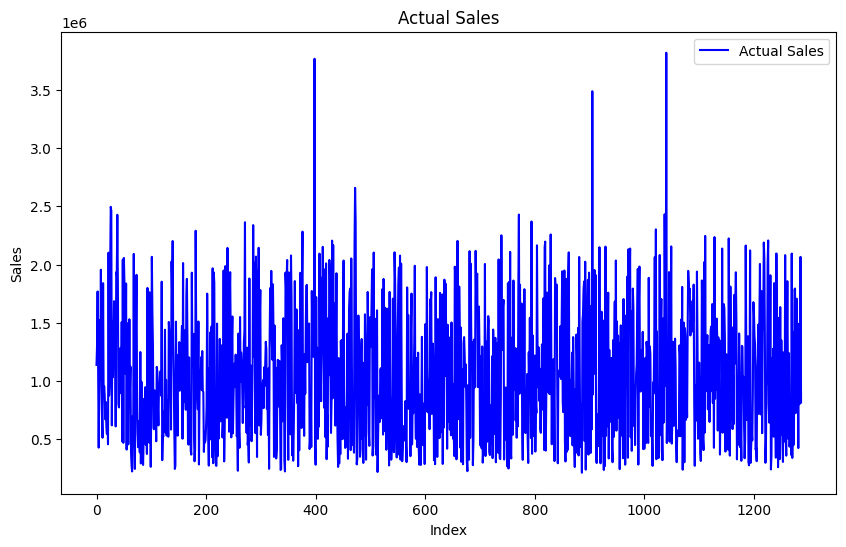

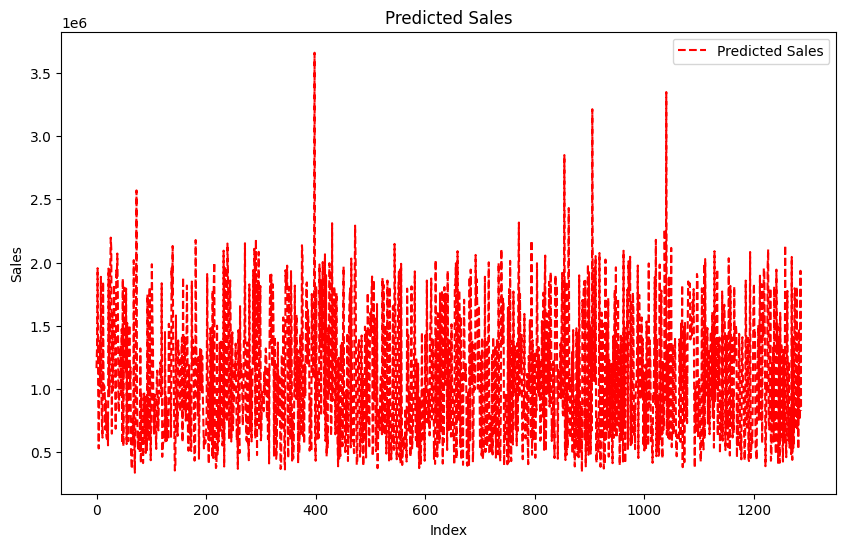

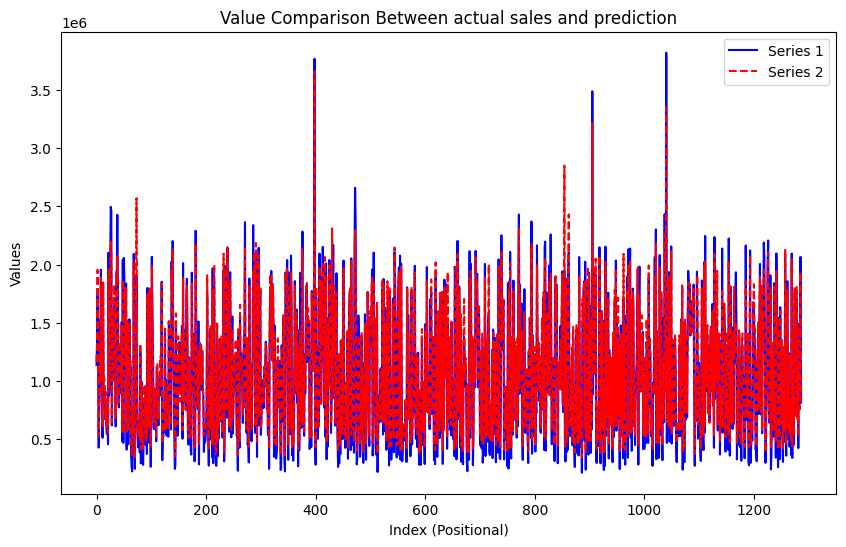

In [ ]:
import matplotlib.pyplot as plt
# Plot 1: Actual Sales
plt.figure(figsize=(10, 6))  # Create the first figure

# Plot the actual values from y_test using its index
plt.plot(y_test, label='Actual Sales', color='blue')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual Sales')

# Add a legend to differentiate the line
plt.legend()

# Display the first plot
plt.show()

# Plot 2: Predicted Sales
plt.figure(figsize=(10, 6))  # Create the second figure

# Plot the predicted values (y_pred_reg) using the same index from y_test
plt.plot(y_pred, label='Predicted Sales', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Predicted Sales')

# Add a legend to differentiate the line
plt.legend()

# Display the second plot
plt.show()

# Plot the two series for comparison, ignoring their indices
plt.figure(figsize=(10, 6))

# Plot the first series (actual values)
plt.plot(y_test, label='Series 1', color='blue')

# Plot the second series (predicted values or comparison values)
plt.plot(y_pred, label='Series 2', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Index (Positional)')
plt.ylabel('Values')
plt.title('Value Comparison Between actual sales and prediction')

# Add legend
plt.legend()

# Show plot
plt.show()


# tuning
Tuning topics included:
* Number of layers and parameter count per layer
* Activation Functions
* Loss Functions
* Learning rates
* Momentum
* Overfitting and regularization



In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import shutil

# Path to the folder you want to delete
folder_path = 'my_dir'

# Delete the folder and all its contents
shutil.rmtree(folder_path)

print(f"Deleted folder: {folder_path}")

Deleted folder: my_dir


In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Define the hypermodel for Keras Tuner
def build_hypermodel(hp):
    model = Sequential()
    # Define the input shape in the first layer
    model.add(Dense(
        units=hp.Int(f'units_0', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(X_train_final.shape[1],)  # Assuming X_train_final is your training data
    ))
    model.add(Dropout(rate=hp.Float(f'dropout_0', min_value=0.1, max_value=0.3, step=0.1)))

    # Add additional layers dynamically
    for i in range(1, hp.Int('num_layers', min_value=5, max_value=7, step=1)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation='relu',
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.3, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model with tunable learning rate (0.0001 to 0.001)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='mse',
        metrics=['root_mean_squared_error']
    )
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_hypermodel,
    objective='val_loss',       # Optimize validation loss
    max_epochs=50,              # epochs for each trial
    factor=3,                   # Reduces learning rate by this factor
    directory='my_dir',         # Directory to save logs
    project_name='sales_forecast' # Project name for the tuning session
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start hyperparameter search
tuner.search(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Trial 90 Complete [00h 00m 36s]
val_loss: 0.07938054949045181

Best val_loss So Far: 0.026177555322647095
Total elapsed time: 00h 19m 07s
Best Hyperparameters:
{'units_0': 256, 'activation': 'relu', 'dropout_0': 0.2, 'num_layers': 6, 'units_1': 192, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.1, 'units_3': 256, 'dropout_3': 0.1, 'units_4': 256, 'dropout_4': 0.1, 'learning_rate': 0.001, 'units_5': 192, 'dropout_5': 0.2, 'units_6': 64, 'dropout_6': 0.1, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 192)                 │          49,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 192)                 │          49,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,209 (1.12 MB)

 Trainable params: 294,209 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def rebuild_tunedmodel(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp[f'units_0'],  # Use the saved value directly
        activation=hp['activation'],
        input_shape=(X_train_final.shape[1],)  # Assuming X_train_final is your training data
    ))
    model.add(Dropout(rate=hp[f'dropout_0']))

    # Additional layers based on num_layers
    for i in range(1, hp['num_layers']):
        model.add(Dense(
            units=hp[f'units_{i}'],
            activation=hp['activation']
        ))
        model.add(Dropout(rate=hp[f'dropout_{i}']))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp['learning_rate']),
        loss='mse',
        metrics=['root_mean_squared_error']
    )
    return model

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)
best_model = rebuild_tunedmodel(best_hyperparameters)
best_model.summary()

Best Hyperparameters:
{'units_0': 256, 'activation': 'relu', 'dropout_0': 0.2, 'num_layers': 6, 'units_1': 192, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.1, 'units_3': 256, 'dropout_3': 0.1, 'units_4': 256, 'dropout_4': 0.1, 'learning_rate': 0.001, 'units_5': 192, 'dropout_5': 0.2, 'units_6': 64, 'dropout_6': 0.1, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 192)                 │          49,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 192)                 │          49,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,209 (1.12 MB)

 Trainable params: 294,209 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

#show graph comparison

Mean Absolute Error (MAE): 61842.60929195804
Mean Squared Error (MSE): 10009950767.023775
Root Mean Squared Error (RMSE): 100049.74146405264
R² Score: 0.9689281113294037
RMSE to Mean: 9.48%
Root Mean Squared Percentage Error (RMSPE): 9.48%
Mean Absolute Percentage Error (MAPE): 6.33%


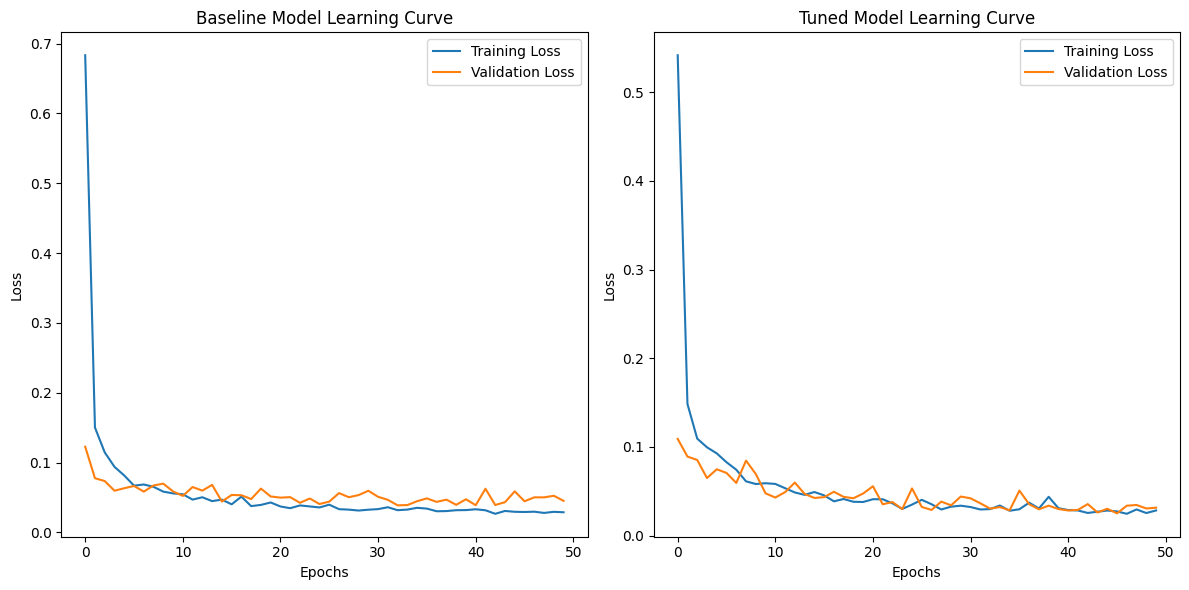

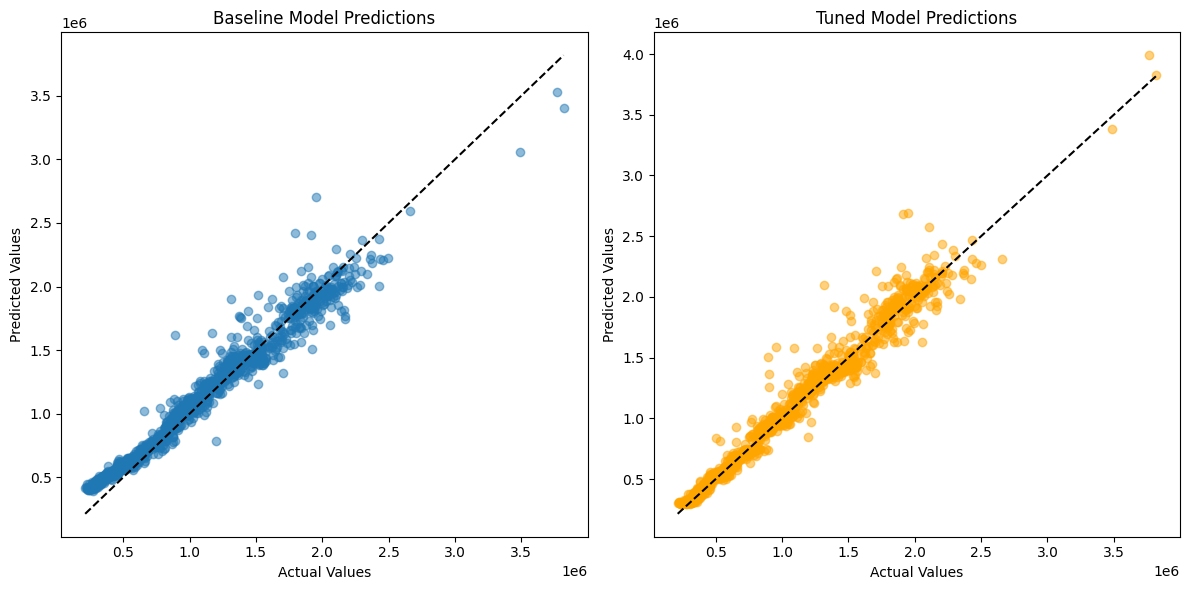

In [ ]:
tuned_model = best_model
tuned_history = tuned_model.fit(X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)

# Predict on the test set
y_pred_tuned = scaler_y.inverse_transform(tuned_model.predict(X_test))
y_pred_tuned = y_pred_tuned.flatten()
# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred_tuned)
mse = mean_squared_error(y_test, y_pred_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_tuned)

# Calculate RMSE to Mean
mean_y_test = np.mean(y_test)
rmse_to_mean = rmse / mean_y_test * 100

# Calculate RMSPE (Root Mean Squared Percentage Error)
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred_tuned) / y_test))) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_tuned) / y_test)) * 100

# Print Results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"RMSE to Mean: {round(rmse_to_mean,2)}%")
print(f"Root Mean Squared Percentage Error (RMSPE): {round(rmspe,2)}%")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape,2)}%")

import matplotlib.pyplot as plt
def plot_learning_curves(history_baseline, history_tuned):
    plt.figure(figsize=(12, 6))

    # Baseline model learning curve
    plt.subplot(1, 2, 1)
    plt.plot(history_baseline.history['loss'], label='Training Loss')
    plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
    plt.title('Baseline Model Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tuned model learning curve
    plt.subplot(1, 2, 2)
    plt.plot(history_tuned.history['loss'], label='Training Loss')
    plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
    plt.title('Tuned Model Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Scatter plot of predictions
def plot_predictions_comparison(y_test, y_pred_baseline, y_pred_tuned):
    plt.figure(figsize=(12, 6))

    # Baseline model predictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_baseline, alpha=0.5)
    plt.title('Baseline Model Predictions')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

    # Tuned model predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_tuned, alpha=0.5, color='orange')
    plt.title('Tuned Model Predictions')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

    plt.tight_layout()
    plt.show()

plot_learning_curves(baseline_history, tuned_history)
plot_predictions_comparison(y_test, y_pred, y_pred_tuned)

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('tuning.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('tuning.csv')

